In [1]:
%matplotlib inline

import pymor.tools.random
pymor.tools.random._default_random_state = None

from IPython import get_ipython
ip = get_ipython()
if ip is not None:
    ip.run_line_magic('load_ext', 'pymor.discretizers.builtin.gui.jupyter')

The pymor.discretizers.builtin.gui.jupyter extension is already loaded. To reload it, use:
  %reload_ext pymor.discretizers.builtin.gui.jupyter


In [2]:
from pymor.analyticalproblems.thermalblock import thermal_block_problem
from pymor.discretizers.builtin import discretize_stationary_cg

p = thermal_block_problem((2,2))
fom, _ = discretize_stationary_cg(p, diameter=1/100)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

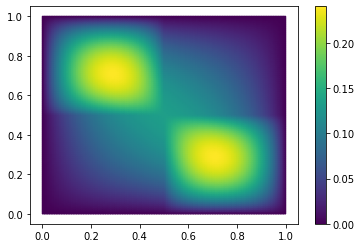

Output()

In [3]:
U = fom.solve([1., 0.1, 0.1, 1.])
fom.visualize(U)

In [4]:
from pymor.algorithms.pod import pod
from matplotlib import pyplot as plt

snapshots = fom.solution_space.empty()
for mu in p.parameter_space.sample_randomly(20):
    snapshots.append(fom.solve(mu))
basis, singular_values = pod(snapshots, modes=10)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

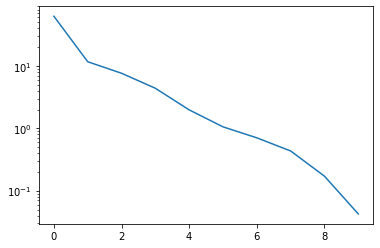

In [5]:
_ = plt.semilogy(singular_values)

In [6]:
from pymor.tools.formatsrc import print_source
print_source(fom.solve)

def solve(self, mu=None, return_output=False, **kwargs):
        """Solve the discrete problem for the |parameter values| `mu`.

        The result will be :mod:`cached <pymor.core.cache>`
        in case caching has been activated for the given model.

        Parameters
        ----------
        mu
            |Parameter values| for which to solve.
        return_output
            If `True`, the model output for the given |parameter values| `mu` is
            returned as a |VectorArray| from :attr:`output_space`.

        Returns
        -------
        The solution |VectorArray|. When `return_output` is `True`,
        the output |VectorArray| is returned as second value.
        """
        if not isinstance(mu, Mu):
            mu = self.parameters.parse(mu)
        assert self.parameters.assert_compatible(mu)
        return self.cached_method_call(self._solve, mu=mu, return_output=return_output, **kwargs)

In [7]:
print_source(fom._solve)

def _solve(self, mu=None, return_output=False):
        # explicitly checking if logging is disabled saves the str(mu) call
        if not self.logging_disabled:
            self.logger.info(f'Solving {self.name} for {mu} ...')

        U = self.operator.apply_inverse(self.rhs.as_range_array(mu), mu=mu)
        if return_output:
            if self.output_functional is None:
                raise ValueError('Model has no output')
            return U, self.output_functional.apply(U, mu=mu)
        else:
            return U

In [8]:
type(fom)

pymor.models.basic.StationaryModel

In [9]:
fom.rhs

NumpyMatrixOperator(<20201x1 dense>, range_id='STATE')

In [10]:
fom.rhs.source

NumpyVectorSpace(1)

In [11]:
from pymor.operators.interface import Operator
print_source(Operator.as_range_array)

def as_range_array(self, mu=None):
        """Return a |VectorArray| representation of the operator in its range space.

        In the case of a linear operator with |NumpyVectorSpace| as
        :attr:`~Operator.source`, this method returns for given |parameter values|
        `mu` a |VectorArray| `V` in the operator's :attr:`~Operator.range`,
        such that ::

            V.lincomb(U.to_numpy()) == self.apply(U, mu)

        for all |VectorArrays| `U`.

        Parameters
        ----------
        mu
            The |parameter values| for which to return the |VectorArray|
            representation.

        Returns
        -------
        V
            The |VectorArray| defined above.
        """
        assert isinstance(self.source, NumpyVectorSpace) and self.linear
        return self.apply(self.source.from_numpy(np.eye(self.source.dim)), mu=mu)

In [12]:
U2 = fom.operator.apply_inverse(fom.rhs.as_range_array(mu), mu=[1., 0.1, 0.1, 1.])

TypeError: mu is not a Mu instance. (Use parameters.parse?)

In [13]:
mu = fom.parameters.parse([1., 0.1, 0.1, 1.])
U2 = fom.operator.apply_inverse(fom.rhs.as_range_array(mu), mu=mu)

In [14]:
(U-U2).norm()

array([0.])

In [15]:
reduced_operator = fom.operator.apply2(basis, basis, mu=mu)
reduced_rhs = basis.inner(fom.rhs.as_range_array(mu))

In [16]:
import numpy as np

u_N = np.linalg.solve(reduced_operator, reduced_rhs)
u_N

array([[-15.16166755],
       [ -1.06060498],
       [ -4.3360103 ],
       [  3.81207226],
       [  2.74026133],
       [  0.98606744],
       [ -0.1756243 ],
       [ -1.26817802],
       [  0.55510353],
       [ -0.0470637 ]])

In [17]:
U_N = basis.lincomb(u_N.T)
U_N

NumpyVectorArray(
    [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.51308241e-04
      2.29395339e-04 8.64727182e-05]],
    NumpyVectorSpace(20201, id='STATE'))

In [18]:
(U-U_N).norm(fom.h1_0_product) / U.norm(fom.h1_0_product)

array([0.01961789])

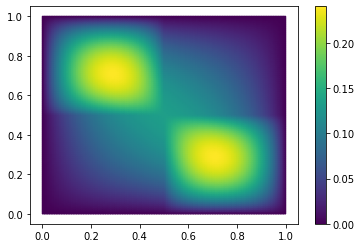

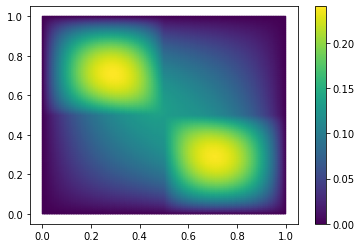

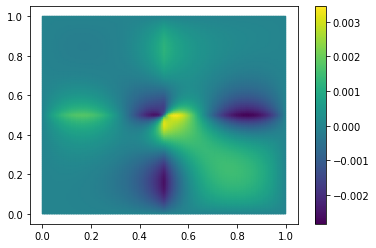

Output()

In [19]:
fom.visualize((U, U_N, U-U_N), separate_colorbars=True)

In [20]:
type(reduced_operator)

numpy.ndarray

In [21]:
from pymor.operators.numpy import NumpyMatrixOperator

reduced_operator = NumpyMatrixOperator(reduced_operator)
reduced_rhs = NumpyMatrixOperator(reduced_rhs)

In [22]:
from pymor.models.basic import StationaryModel
rom = StationaryModel(reduced_operator, reduced_rhs)
rom

StationaryModel(NumpyMatrixOperator(<10x10 dense>), NumpyMatrixOperator(<10x1 dense>), products={})

In [23]:
u_N2 = rom.solve()
u_N.T - u_N2.to_numpy()

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [24]:
print(fom.parameters)
print(rom.parameters)

{diffusion: 4}
{}


In [25]:
from time import perf_counter

tic = perf_counter()
fom.solve(mu)
toc = perf_counter()
fom.operator.apply2(basis, basis, mu=mu)
basis.inner(fom.rhs.as_range_array(mu))
tac = perf_counter()
rom.solve()
tuc = perf_counter()
print(f'FOM:          {toc-tic:.5f} (s)')
print(f'ROM assemble: {tac-toc:.5f} (s)')
print(f'ROM solve:    {tuc-tac:.5f} (s)')

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

FOM:          0.10243 (s)
ROM assemble: 0.01171 (s)
ROM solve:    0.00133 (s)


In [26]:
fom.operator

LincombOperator(
    (NumpyMatrixOperator(<20201x20201 sparse, 140601 nnz>, source_id='STATE', range_id='STATE', name='boundary_part'),
     NumpyMatrixOperator(<20201x20201 sparse, 140601 nnz>, source_id='STATE', range_id='STATE', name='diffusion_0'),
     NumpyMatrixOperator(<20201x20201 sparse, 140601 nnz>, source_id='STATE', range_id='STATE', name='diffusion_1'),
     NumpyMatrixOperator(<20201x20201 sparse, 140601 nnz>, source_id='STATE', range_id='STATE', name='diffusion_2'),
     NumpyMatrixOperator(<20201x20201 sparse, 140601 nnz>, source_id='STATE', range_id='STATE', name='diffusion_3')),
    (1.0,
     ProjectionParameterFunctional('diffusion', size=4, index=0, name='diffusion_0_0'),
     ProjectionParameterFunctional('diffusion', size=4, index=1, name='diffusion_1_0'),
     ProjectionParameterFunctional('diffusion', size=4, index=2, name='diffusion_0_1'),
     ProjectionParameterFunctional('diffusion', size=4, index=3, name='diffusion_1_1')),
    name='ellipticOperator')

In [27]:
reduced_operators = [NumpyMatrixOperator(op.apply2(basis, basis))
                     for op in fom.operator.operators]

In [28]:
reduced_operator = fom.operator.with_(operators=reduced_operators)

In [29]:
fom.rhs.parameters

Parameters({})

In [30]:
rom = StationaryModel(reduced_operator, reduced_rhs)

In [31]:
rom.parameters

Parameters({diffusion: 4})

In [32]:
u_N3 = rom.solve(mu)
u_N.T - u_N3.to_numpy()

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [33]:
tic = perf_counter()
fom.solve(mu)
toc = perf_counter()
rom.solve(mu)
tac = perf_counter()
print(f'FOM: {toc-tic:.5f} (s)')
print(f'ROM: {tac-toc:.5f} (s)')

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

FOM: 0.10122 (s)
ROM: 0.00146 (s)


In [34]:
from pymor.algorithms.projection import project

reduced_operator = project(fom.operator, basis, basis)
reduced_rhs      = project(fom.rhs,      basis, None )

In [35]:
reduced_operator

LincombOperator(
    (NumpyMatrixOperator(<10x10 dense>, name='boundary_part'),
     NumpyMatrixOperator(<10x10 dense>, name='diffusion_0'),
     NumpyMatrixOperator(<10x10 dense>, name='diffusion_1'),
     NumpyMatrixOperator(<10x10 dense>, name='diffusion_2'),
     NumpyMatrixOperator(<10x10 dense>, name='diffusion_3')),
    (1.0,
     ProjectionParameterFunctional('diffusion', size=4, index=0, name='diffusion_0_0'),
     ProjectionParameterFunctional('diffusion', size=4, index=1, name='diffusion_1_0'),
     ProjectionParameterFunctional('diffusion', size=4, index=2, name='diffusion_0_1'),
     ProjectionParameterFunctional('diffusion', size=4, index=3, name='diffusion_1_1')),
    name='ellipticOperator')

In [36]:
rom = StationaryModel(reduced_operator, reduced_rhs)
u_N4 = rom.solve(mu)
u_N.T - u_N4.to_numpy()

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [37]:
print_source(project)

def project(op, range_basis, source_basis, product=None):
    """Petrov-Galerkin projection of a given |Operator|.

    Given an inner product `( ⋅, ⋅)`, source vectors `b_1, ..., b_N`
    and range vectors `c_1, ..., c_M`, the projection `op_proj` of `op`
    is defined by ::

        [ op_proj(e_j) ]_i = ( c_i, op(b_j) )

    for all i,j, where `e_j` denotes the j-th canonical basis vector of R^N.

    In particular, if the `c_i` are orthonormal w.r.t. the given product,
    then `op_proj` is the coordinate representation w.r.t. the `b_i/c_i` bases
    of the restriction of `op` to `span(b_i)` concatenated with the
    orthogonal projection onto `span(c_i)`.

    From another point of view, if `op` is viewed as a bilinear form
    (see :meth:`apply2`) and `( ⋅, ⋅ )` is the Euclidean inner
    product, then `op_proj` represents the matrix of the bilinear form restricted
    to `span(b_i) / span(c_i)` (w.r.t. the `b_i/c_i` bases).

    How the projection is realized will depend on the given |Operator|.
    While a projected |NumpyMatrixOperator| will
    again be a |NumpyMatrixOperator|, only a generic
    :class:`~pymor.operators.constructions.ProjectedOperator` can be returned
    in general. The exact algorithm is specified in :class:`ProjectRules`.

    Parameters
    ----------
    range_basis
        The vectors `c_1, ..., c_M` as a |VectorArray|. If `None`, no
        projection in the range space is performed.
    source_basis
        The vectors `b_1, ..., b_N` as a |VectorArray| or `None`. If `None`,
        no restriction of the source space is performed.
    product
        An |Operator| representing the inner product.  If `None`, the
        Euclidean inner product is chosen.

    Returns
    -------
    The projected |Operator| `op_proj`.
    """
    assert source_basis is None or source_basis in op.source
    assert range_basis is None or range_basis in op.range
    assert product is None or product.source == product.range == op.range

    rb = product.apply(range_basis) if product is not None and range_basis is not None else range_basis

    try:
        return ProjectRules(rb, source_basis).apply(op)
    except NoMatchingRuleError:
        op.logger.warning('Using inefficient generic projection operator')
        return ProjectedOperator(op, range_basis, source_basis, product)

In [38]:
from pymor.algorithms.projection import ProjectRules
ProjectRules

Pos  Match Type  Condition                      Action Name / Action Description
---  ----------  -----------------------------  --------------------------------
0    ALWAYS      None                           no_bases                        
1    CLASS       ZeroOperator                   ZeroOperator                    
2    CLASS       ConstantOperator               ConstantOperator                
3    GENERIC     linear and not parametric      apply_basis                     
4    CLASS       ConcatenationOperator          ConcatenationOperator           
5    CLASS       AdjointOperator                AdjointOperator                 
6    CLASS       EmpiricalInterpolatedOperator  EmpiricalInterpolatedOperator   
7    CLASS       AffineOperator                 AffineOperator                  
8    CLASS       LincombOperator                LincombOperator                 
9    CLASS       SelectionOperator              SelectionOperator               
10   CLASS       BlockOperat

In [39]:
assert ProjectRules.rules[8].action_description == 'LincombOperator'

In [40]:
ProjectRules.rules[8]

@match_class(LincombOperator)
    def action_LincombOperator(self, op):
        return self.replace_children(op).with_(solver_options=None)

In [41]:
assert ProjectRules.rules[3].action_description == 'apply_basis'

In [42]:
ProjectRules.rules[3]

@match_generic(lambda op: op.linear and not op.parametric, 'linear and not parametric')
    def action_apply_basis(self, op):
        range_basis, source_basis = self.range_basis, self.source_basis
        if source_basis is None:
            try:
                V = op.apply_adjoint(range_basis)
            except NotImplementedError:
                raise RuleNotMatchingError('apply_adjoint not implemented')
            if isinstance(op.source, NumpyVectorSpace):
                from pymor.operators.numpy import NumpyMatrixOperator
                return NumpyMatrixOperator(V.to_numpy(), source_id=op.source.id, name=op.name)
            else:
                from pymor.operators.constructions import VectorArrayOperator
                return VectorArrayOperator(V, adjoint=True, name=op.name)
        else:
            if range_basis is None:
                V = op.apply(source_basis)
                if isinstance(op.range, NumpyVectorSpace):
                    from pymor.operators.numpy import NumpyMatrixOperator
                    return NumpyMatrixOperator(V.to_numpy().T, range_id=op.range.id, name=op.name)
                else:
                    from pymor.operators.constructions import VectorArrayOperator
                    return VectorArrayOperator(V, adjoint=False, name=op.name)
            else:
                from pymor.operators.numpy import NumpyMatrixOperator
                return NumpyMatrixOperator(op.apply2(range_basis, source_basis), name=op.name)

In [43]:
from pymor.reductors.basic import StationaryRBReductor

reductor = StationaryRBReductor(fom, basis)
rom = reductor.reduce()

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [44]:
u_N5 = rom.solve(mu)
u_N.T - u_N5.to_numpy()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [45]:
print_source(reductor.project_operators)

def project_operators(self):
        fom = self.fom
        RB = self.bases['RB']
        projected_operators = {
            'operator':          project(fom.operator, RB, RB),
            'rhs':               project(fom.rhs, RB, None),
            'products':          {k: project(v, RB, RB) for k, v in fom.products.items()},
            'output_functional': project(fom.output_functional, None, RB) if fom.output_functional else None
        }
        return projected_operators

In [46]:
print_source(reductor.build_rom)

def build_rom(self, projected_operators, error_estimator):
        return StationaryModel(error_estimator=error_estimator, **projected_operators)

In [47]:
U_N5 = reductor.reconstruct(u_N5)
(U_N - U_N5).norm()

array([0.])

In [48]:
print_source(reductor.reconstruct)

def reconstruct(self, u, basis='RB'):
        """Reconstruct high-dimensional vector from reduced vector `u`."""
        return self.bases[basis][:u.dim].lincomb(u.to_numpy())